Recurrent Neural Networks (RNN)
====================

In this exercise we will work with Recurrent Neural Networks (RNN). A RNN is class of neural networks where the output not only depends on the current input but also on previous inputs along a given input sequence. This allows to exhibit temporal dynamic behaviour and contextual information in a sequence. Common applications for RNN are:

- time series analysis
- speech recognition
- machine translation
- image captioning


Goal of this exercise
========

This exercise notebook should help you to experiment how recurrent neural networks are implemented, trained, and used for computer vision problems. Therefore, this notebook is structured as follows:
1. Implement your own simple RNN class in Pytorch.
2. Explore the backpropagation of the gradients in the RNN and discuss the vanishing gradient problem.
3. Implement your own LSTM (Long-Short Term Memory) Network and show that this architecture improves the vanishing gradient problem.
4. Build RNN and LSTM classifier for the MNIST dataset and train your model.
5. Submit your best model to the server to get bonus points.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import platform
print('Using python: ', platform.python_version())
print('Using torch version: ', torch.__version__)
print('Using device: ', device)
# Machine: 2015 13" Macbook Pro, i5 dual core

Using python:  3.8.3
Using torch version:  1.5.0
Using device:  cpu


## Simple Recurrent Neural Network

The recurrent loops in a RNN allow relevant information to persist over time. A simple RNN architecture is shown here:
<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png width="150">

A simple RNN takes not only an input X at time step t but also passes a hidden state that is the output of the previous time step into the network. The output of a RNN cell at time step t reads in Eq. 1:

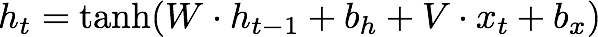

In this task you have to implement a simple one-layer RNN as a class in Pytorch, where you can choose a relu or tanh activation in the cell.You can see the architecture of a simple RNN in the figure below.

#### Define your model in the provided file `exercise_code/rnn/rnn_nn.py` file


<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png width="600">



In [3]:
# T0D0: Implement the RNN class
from exercise_code.rnn.rnn_nn import RNN

Luckily, Pytorch already has implemented a simple RNN in their library and you can call the RNN with <code>nn.RNN</code>. We will use the Pytorch RNN function to check if we have built the correct cell and compare the output of both functions. We also compare the running time of both classes.

In [4]:
import torch.nn as nn
import timeit

# choose your network parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_rnn=nn.RNN(input_size, hidden_dim)
i2dl_rnn=RNN(input_size, hidden_dim)

# initialise both rnn with same values
for p in pytorch_rnn.parameters():
    nn.init.constant_(p, val=0.3)
for p in i2dl_rnn.parameters():
    nn.init.constant_(p, val=0.3)
    
X=torch.randn(seq_len, 1, input_size)

output_pytorch, h_pytorch = pytorch_rnn(X)
output_i2dl, h_i2dl = i2dl_rnn(X)


# The difference of outputs should be 0!!

diff = torch.sum((output_pytorch-output_i2dl)**2)
print("Differnce between pytorch and your RNN implementation: %s" %diff.item())
if diff.item()<10**-10:
    print("Cool, you implemented a correct model.")
else:
    print("Upps! There is something wrong in your model. Try again!")

Differnce between pytorch and your RNN implementation: 1.0658141036401503e-14
Cool, you implemented a correct model.


In [5]:
import timeit
runs=10**4

print("Time Pytorch RNN {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_rnn(X)", 
                                       setup="from __main__ import pytorch_rnn, X", 
                                       number=runs))
     )

print("Time I2DL RNN {} run: {:.3f}s".format(runs, timeit.timeit("i2dl_rnn(X)", 
                                       setup="from __main__ import i2dl_rnn, X", 
                                       number=runs))
     )

Time Pytorch RNN 10000 runs: 3.112s
Time I2DL RNN 10000 run: 11.360s


From now on we will use the Pytorch module that is faster and optimised in performance. However, it is always a good exercise to build the functions by yourself and we really advice you to do the exercise!

## Vanishing Gradient

As discussed in the lecture, the simple RNN suffers from vanishing gradients in the backpropagation. The hidden state is manipulated in every time step along the sequence and the effect of the past inputs to the final output vanishes with the distance in time. In the next cell we will explore the vanishing effect of previous inputs in the RNN.

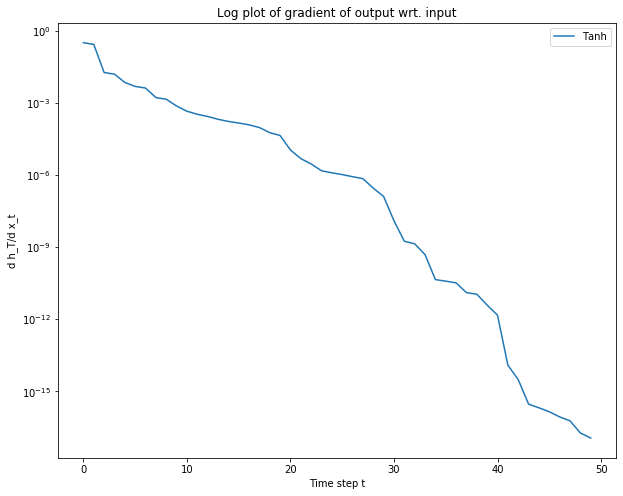

In [6]:

hidden_size=1
input_size= 1

time_steps=50
rnn=RNN(input_size, hidden_size)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad=True
_,h=rnn(X)
h.requires_grad
h.sum().backward()
grad_tanh=X.grad.view(-1)

plt.semilogy(np.flip(abs(grad_tanh.detach().cpu().numpy())), label="Tanh")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show() 



<div class="alert alert-info">
    <h3>Note</h3>
    <p>It can be seen that the gradient of the of the output at time t wrt. to a previous input decreases exponentially. Hence, the final output does not change significantly for changes in the previous input and hence the RNN does not have memory.</p> 
<h3>Question</h3> 
<p>In order to better understand the vanishing gradient problem, calculate the gradients 
dh_t/dV, dh_t /dW, and dh_t/dX_0 analytically for t=3 and h_0=0 using Eq. 1. This exercise might seem a little bit tedious but it is really useful. Can you explain the vanishing gradient mathematically based on your findings?</p>
</div>

## Long-Short Term Memory Network (LSTM)
The vanishing gradient problem had been known for some time until Schmidhuber (1997) developed the Long-Short Term Memory Network and showed that this architecture can overcome the problem. <br> 
A LSTM is a more advanced recurrent network architecture that is able to learn long time dependencies. The architecture of a LSTM is composed of a forget, input, and output gate and the cell can remember values over arbitrary time intervals. Despite various different and exotic LSTM architectures, the standard LSTM cell is shwon in the figure below:


<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png width="600">



Compared to a simple RNN the LSTM cell has a hidden vector and an additional cell state vector. __What size does the cell state have?__ <br>
The operations inside the LSTM are given as 

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/2db2cba6a0d878e13932fa27ce6f3fb71ad99cf1  width="600">
where 
f_t: forget gate,  <br>
i_t: input gate, <br>
o_t: output gate, <br>
h_t: hidden state vector, <br>
c_t: cell state vector, <br>
x_t: input vector, <br>
t is time step, 
<br> 
<br> 
and<br> 
sigma_g: sigmoid activation <br> 
sigma_c and sigma_h: hyperbolic tangent function


In the next step you should implement your own LSTM with the operations stated above.
#### Define your model in the provided file `exercise_code/rnn/rnn_nn.py` file


In [7]:
# TODO: Implement the RNN class
from exercise_code.rnn.rnn_nn import LSTM

In [8]:

# choose your input parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_lstm=nn.LSTM(input_size, hidden_dim)
i2dl_lstm=LSTM(input_size, hidden_dim)

# initialise both lstms with same values
for p in pytorch_lstm.parameters():
    nn.init.constant_(p, val=0.3)
for p in i2dl_lstm.parameters():
    nn.init.constant_(p, val=0.3)
    
X=torch.randn(seq_len, 1, input_size)

output_pytorch, (h_pytorch, _) = pytorch_lstm(X)
output_i2dl , (h_i2dl, _ )= i2dl_lstm(X)

# The difference of outputs should be 0!!
diff = torch.sum((output_pytorch-output_i2dl)**2)
print("Differnce between pytorch and your RNN implementation: %s" %diff.item())
if diff.item()<10**-10:
    print("Cool, you implemented a correct model.")
else:
    print("Upps! There is something wrong in your model. Try again!")

Differnce between pytorch and your RNN implementation: 5.3152835323248826e-14
Cool, you implemented a correct model.


In [9]:
import timeit
runs=10**4

print("Time Pytorch LSTM {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_lstm(X)", 
                                       setup="from __main__ import pytorch_lstm, X", 
                                       number=runs))
     )

print("Time I2DL LSTM {} run: {:.3f}s".format(runs, timeit.timeit("i2dl_lstm(X)", 
                                       setup="from __main__ import i2dl_lstm, X", 
                                       number=runs))
     )

Time Pytorch LSTM 10000 runs: 7.868s
Time I2DL LSTM 10000 run: 37.916s


## Explore Gradients
Analogously to the RNN, calculate the gradients of the input wrt. to the output of the LSTM and compare it against the RNN gradients. __What do you see?__


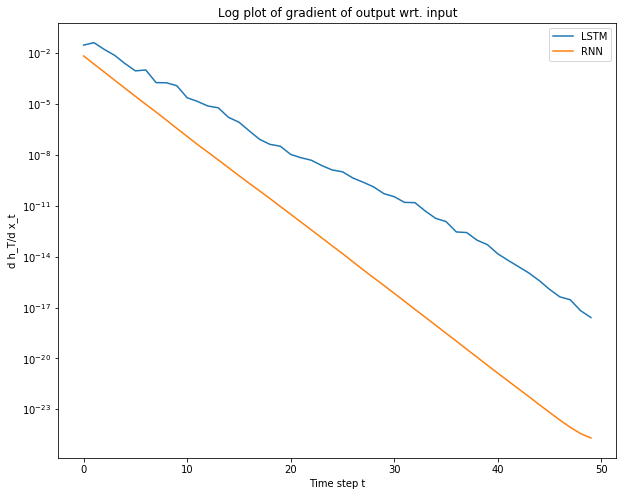

In [10]:

hidden_size=1
input_size= 1

time_steps=50
rnn=RNN(input_size, hidden_size)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad=True
_,h=rnn(X)
h.requires_grad
h.sum().backward()
grad_rnn=X.grad.view(-1)

lstm=LSTM(input_size, hidden_size)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad=True
_,(h, c)=lstm(X)
h.sum().backward()
grad_lstm=X.grad.view(-1)

plt.semilogy(np.flip(abs(grad_lstm.detach().cpu().numpy())) , label="LSTM")
plt.semilogy(np.flip(abs(grad_rnn.detach().cpu().numpy())), label="RNN")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show() 


## MNIST image classification with RNNs


<div class="alert alert-info">
    <h3>Note</h3>
    <p>
    In this semester you have seen three different types of neural networks, namely Multi-Layer Perceptrons (MLPs), Convolutional Neural Networks (CNNs), and now Recurrent Neural Networks (RNNs). We have seen that we can use all three architectures for image classification. However, it turned out that some models are better than others for image classification. Try to think about advantages and disadvantages of the models, regarding # of parameters, transformations of the object in the image (scaling, rotation, translation,...), training time, testing time, over-fitting, etc.

## Step 0: Prepare MNIST Dataset 

In this exercise, we will solve the problem of image classification with a recurrent neural network.  

For the experiment we use the MNIST handwritten digits dataset which we already know from the autoencoder exercise. This dataset consists of images of the 10 different digits (10 classes). The images have the resolution 28 x 28. 

To acquire the dataset, you can simply run the following code or use the alternative link we provided to download manually.

After successfully downloading the MNIST dataset, let's visualize some examples from the dataset, we will show a few examples of training images from each class.

In [11]:
from exercise_code.util.download_utils import download_dataset
download_url = 'http://filecremers3.informatik.tu-muenchen.de/~dl4cv/mnist_train.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','mnist')

download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='mnist_data.zip',
    force_download=False,
)

0it [00:00, ?it/s]

9986048it [00:30, 937265.76it/s]                              

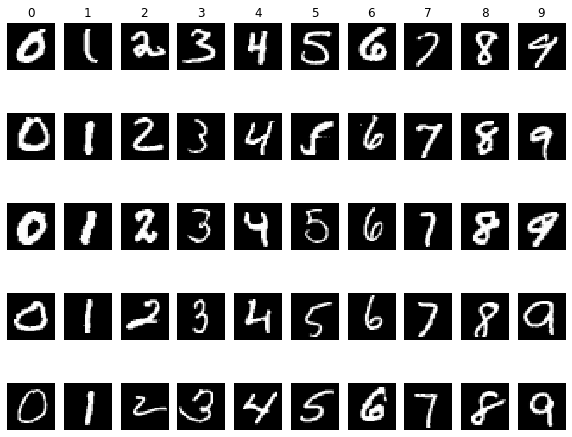

In [12]:

# loading the train data
from exercise_code.rnn.mnist_dataset import *

import pickle
from torchvision import transforms
    
# transformation of data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# read dataset
path = os.path.join(data_root,"mnist_train.p")

with open(path, "rb") as f:
    mnist_raw = pickle.load(f)

# split the dataset
X, y= mnist_raw
train_split=0.85
train_dset=MnistDataset(X[:int(len(X)*train_split)], y[:int(len(X)*train_split)], transform=transform)
val_dset=MnistDataset(X[int(len(X)*train_split):], y[int(len(X)*train_split):], transform=transform)


X=train_dset.images
y=train_dset.labels

# training sample visualization
classes = list(range(10))
num_classes = len(classes)
samples_per_class = 5
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(train_dset.labels == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Step 1: Design your own model
Now it is your turn to build your own model. The idea for the RNN classifier and LSTM classifier is to interpret the image as a sequence of rows. This means that we pass the rows through the RNN or LSTM and use the final hidden state for classification. To do so, you may use RNN and LSTM network you just wrote and add linear layer(s) for classfication at the end of your model. You can also checke the following architecture as a hint for your classifer design.

<img src=https://cdn-images-1.medium.com/max/800/1*Cm_c-I02rBa1rtLZXBhNUw.png width="600">

#### Define your classifier in the provided file `exercise_code/rnn/classifier.py` file

This file is mostly empty but contains the expected class name, and the methods that your model (RNN_Classifier and LSTM_Classifier) needs to implement (only `__init__()` and `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from pytorch_lightning.LightningModule, which we have implemented in base_classifier.py
* Define necessary layers in your classifier model in `__init__()`
* Perform the forward pass in `forward()`, predicting the class of a given MNIST sample

## Step 2: Train your model
In addition to the network itself, you will also need to write the code for the model training. You may use PyTorch Lightning (stronly recomanded) to define a trainer for that, or you can also write it yourself in standard PyTorch.


### TODO: Train your RNN classifier

In this part, you need to train your RNN classifier at first. With your simple RNN classifier you should exceed an accuracy higher than __90%__.


In [29]:
from exercise_code.rnn.classifier import RNN_Classifier

path =os.path.join(data_root,"mnist_train.p")
model_rnn = RNN_Classifier()
model_rnn.set_data_path(path)

In [30]:
import pytorch_lightning as pl

########################################################################
# TODO - Train Your Model                                              #
########################################################################

trainer = pl.Trainer(
    # weights_summary=None,
    max_epochs=10,
)

trainer.fit(model_rnn)

############################################################################
#                             END OF YOUR CODE                             #
############################################################################

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name     | Type   | Params
--------------------------------
0 | rnn      | RNN    | 20 K  
1 | FC_layer | Linear | 1 K   


/Users/salihyurtkulu/anaconda3/envs/i2dl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


valiadation accuracy at currect epoch is 0.08984375


valiadation accuracy at currect epoch is 0.8045114278793335


/Users/salihyurtkulu/anaconda3/envs/i2dl/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


valiadation accuracy at currect epoch is 0.8995818495750427


valiadation accuracy at currect epoch is 0.9086267352104187


valiadation accuracy at currect epoch is 0.9410651922225952


valiadation accuracy at currect epoch is 0.9448503255844116


valiadation accuracy at currect epoch is 0.9504181742668152


valiadation accuracy at currect epoch is 0.9573503732681274


valiadation accuracy at currect epoch is 0.9609375


valiadation accuracy at currect epoch is 0.9589127898216248


valiadation accuracy at currect epoch is 0.970598578453064



1

### TODO: Train  your LSTM classifier

Now you may try to imporve your model by using LSTM intead of RNN, notes that you need to submit your LSTM model for final evaluation to get bonus.

In [34]:
from exercise_code.rnn.classifier import LSTM_Classifier

path = os.path.join(data_root,"mnist_train.p")

model_lstm = LSTM_Classifier()
model_lstm.set_data_path(path)
model_lstm.prepare_data()

In [35]:
import pytorch_lightning as pl

########################################################################
# TODO - Train Your Model                                              #
########################################################################
trainer = pl.Trainer(
    # weights_summary=None,
    max_epochs=10,
)

trainer.fit(model_lstm)
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name     | Type   | Params
--------------------------------
0 | lstm     | LSTM   | 80 K  
1 | FC_layer | Linear | 1 K   


valiadation accuracy at currect epoch is 0.125


valiadation accuracy at currect epoch is 0.9438599944114685


valiadation accuracy at currect epoch is 0.960585355758667


valiadation accuracy at currect epoch is 0.9722490906715393


valiadation accuracy at currect epoch is 0.9762324094772339


valiadation accuracy at currect epoch is 0.9789832830429077


valiadation accuracy at currect epoch is 0.964304506778717


valiadation accuracy at currect epoch is 0.9810519218444824


valiadation accuracy at currect epoch is 0.9784990549087524


valiadation accuracy at currect epoch is 0.9827244877815247


valiadation accuracy at currect epoch is 0.9755281209945679



1

## Save Your Model

When you are satisfied with your training, you can save your LSTM classifier.

In [ ]:
from exercise_code.util import save_model
save_model(model_lstm, "lstm_mnist_nn.p")

# Submission Instructions
1. Go on [our submission page](https://dvl.in.tum.de/teaching/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an ID which we need in the next step.
2. Navigate to `exercise_code` directory and run the `create_submission.sh` file to create the zip file of your model. This will create a single `zip` file that you need to upload. Otherwise, you can also zip it manually if you don't want to use the bash script. However, **make sure that the structure of the zip file is the same** as it would be when generated with the bash-script.
3. Log into [our submission page](https://dvl.in.tum.de/teaching/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted file selectable on the top.
4. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

# Submission Goals

- Goal: Implement and train a convolutional neural network for facial keypoint detection.
- Passing Criteria: Reach **Score >= 90** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __Thrusday, June 10, 2020 - 12:00__
- Submission deadline : __Wednesday, July 16, 2020 - 23:59__ 
- There is no limit for the number of submissions. Your __best submission__ will be considered for bonus